# deepctr

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
from copy import deepcopy
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from hyperopt import hp
from deepctr.models import xDeepFM
from deepctr.inputs import  SparseFeat, DenseFeat, get_feature_names
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, LE, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

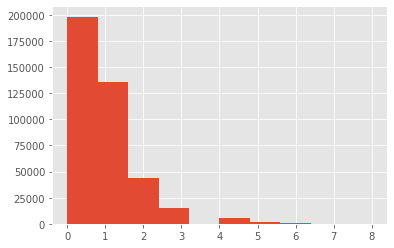

In [4]:
test_df.isna().sum(axis=1).hist()

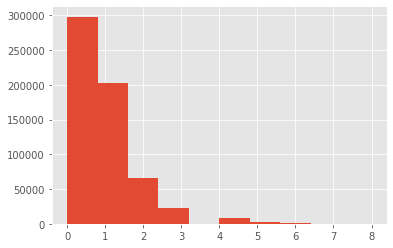

In [5]:
train_df.isna().sum(axis=1).hist()

In [6]:
# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [22]:
for col in train_df.columns:
    top = train_df[col].head(100000).value_counts(normalize=True).head(10)
    test_top = test_df[col].head(100000).value_counts(normalize=True).head(10)
    train = train_df[col].value_counts(normalize=True).head(10)
    test = test_df[col].value_counts(normalize=True).head(10)
    print(train-top)
    print(train-test)
    print('*********')

0.0       0.000148
1.0      -0.000212
isnull    0.000063
Name: bin_0, dtype: float64
0.0       0.001186
1.0      -0.001257
isnull    0.000071
Name: bin_0, dtype: float64
*********
0.0      -0.000800
1.0       0.001015
isnull   -0.000215
Name: bin_1, dtype: float64
0.0       0.001648
1.0      -0.001557
isnull   -0.000090
Name: bin_1, dtype: float64
*********
0.0      -0.001708
1.0       0.001175
isnull    0.000533
Name: bin_2, dtype: float64
0.0      -0.000253
1.0       0.000300
isnull   -0.000047
Name: bin_2, dtype: float64
*********
F        -0.002547
T         0.002133
isnull    0.000413
Name: bin_3, dtype: float64
F         0.000123
T        -0.000269
isnull    0.000146
Name: bin_3, dtype: float64
*********
N         0.000723
Y        -0.000772
isnull    0.000048
Name: bin_4, dtype: float64
N        -0.000494
Y         0.000293
isnull    0.000201
Name: bin_4, dtype: float64
*********
Red       0.000300
Blue     -0.000068
Green    -0.000282
isnull    0.000050
Name: nom_0, dtype: floa

0   -0.000673
1    0.001980
2   -0.001560
3    0.000042
4   -0.000003
5    0.000168
6    0.000077
7   -0.000037
8         NaN
Name: null, dtype: float64
0    0.001332
1   -0.001478
2    0.000205
3    0.000264
4   -0.000148
5   -0.000144
6   -0.000038
7    0.000016
8   -0.000008
Name: null, dtype: float64
*********
